# Repair Cost Prediction API

This project develops and deploys a machine learning model that predicts **repair costs** based on product information, date-related features, and defect characteristics.

## Problem Description

Accurately estimating repair costs helps organizations plan budgets, optimize maintenance schedules, and allocate resources more effectively.  
This project provides a machine learning–powered API that predicts **repair cost** from historical defect data, enabling automation and smarter decision-making.

The service can be integrated into dashboards, monitoring tools, or automated workflows.

## Dataset information:
This dataset contains simulated data related to manufacturing defects observed during quality control processes. It includes information such as defect type, detection date, location within the product, severity level, inspection method used, and repair costs. This dataset can be used for analyzing defect patterns, improving quality control processes, and assessing the impact of defects on product quality and production costs. Columns:

- defect_id: Unique identifier for each defect.
- product_id: Identifier for the product associated with the defect.
- defect_type: Type or category of the defect (e.g., cosmetic, functional, structural).
- defect_description: Description of the defect.
- defect_date: Date when the defect was detected.
- defect_location: Location within the product where the defect was found (e.g., surface, component).
- severity: Severity level of the defect (e.g., minor, moderate, critical).
- inspection_method: Method used to detect the defect (e.g., visual inspection, automated testing).
- repair_action: Action taken to repair or address the defect.
- repair_cost: Cost incurred to repair the defect (in local currency).

Dataset: https://www.kaggle.com/datasets/fahmidachowdhury/manufacturing-defects/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
data = "defects_data.csv"
df = pd.read_csv(data)
df.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64


## Data Preparation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


In [4]:
df.describe()

,defect_id,product_id,repair_cost
count,1000.000000,1000.000000,1000.000000
mean,500.500000,50.837000,507.627150
std,288.819436,29.480935,289.623615
min,1.000000,1.000000,10.220000
25%,250.750000,26.000000,270.902500
50%,500.500000,51.000000,506.430000
75%,750.250000,77.000000,759.065000
max,1000.000000,100.000000,999.640000


In [5]:
df["defect_id"] = df["defect_id"].astype(str)
df["product_id"] = df["product_id"].astype(str)

In [6]:
df.isnull().sum()

defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
dtype: int64

In [7]:
df.nunique()

defect_id            1000
product_id            100
defect_type             3
defect_date           182
defect_location         3
severity                3
inspection_method       3
repair_cost           996
dtype: int64

In [8]:
df["date_converted"] = pd.to_datetime(df["defect_date"])

In [9]:
df["year"] = df["date_converted"].dt.year
df["month"] = df["date_converted"].dt.month
df["day_of_week"] = df["date_converted"].dt.dayofweek

In [10]:
df.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost,date_converted,year,month,day_of_week
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47,2024-06-06,2024,6,3
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87,2024-04-26,2024,4,4
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81,2024-02-15,2024,2,3
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47,2024-03-28,2024,3,3
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64,2024-04-26,2024,4,4


## Exploratory Data Analysis

<Axes: xlabel='repair_cost', ylabel='Count'>

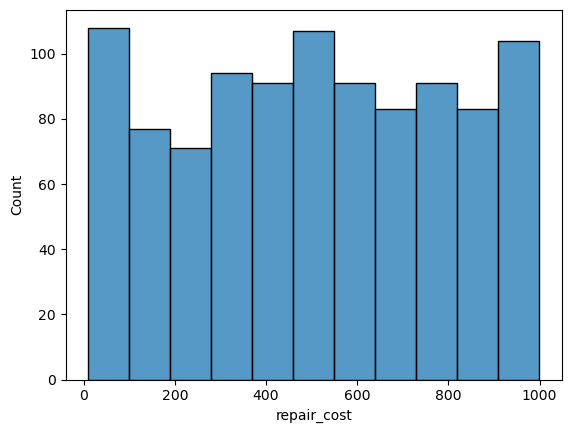

In [11]:
sns.histplot(df["repair_cost"])

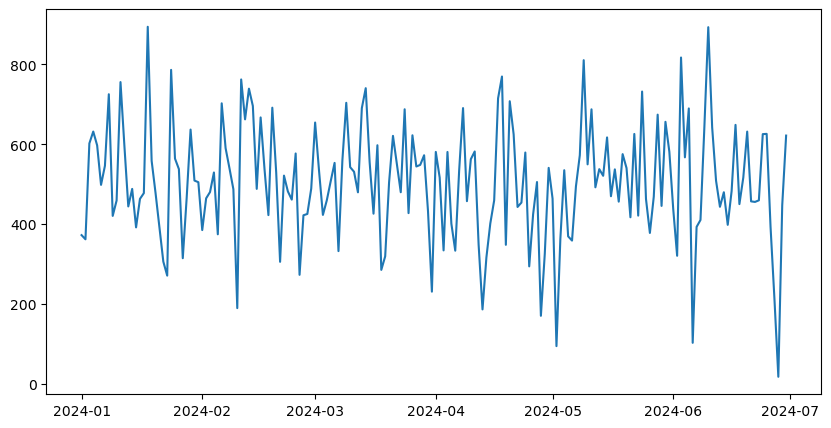

In [12]:
plt.figure(figsize=(10,5))
avg_cost_date = df.groupby("date_converted")["repair_cost"].mean().reset_index()
plt.plot(avg_cost_date["date_converted"], avg_cost_date["repair_cost"])

In [13]:
print(df["year"].nunique())
print(df["month"].nunique())
print(df["day_of_week"].nunique())

1
6
7


In [14]:
df["month"].unique()

array([6, 4, 2, 3, 5, 1], dtype=int32)

In [15]:
# months from January to June
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]

day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

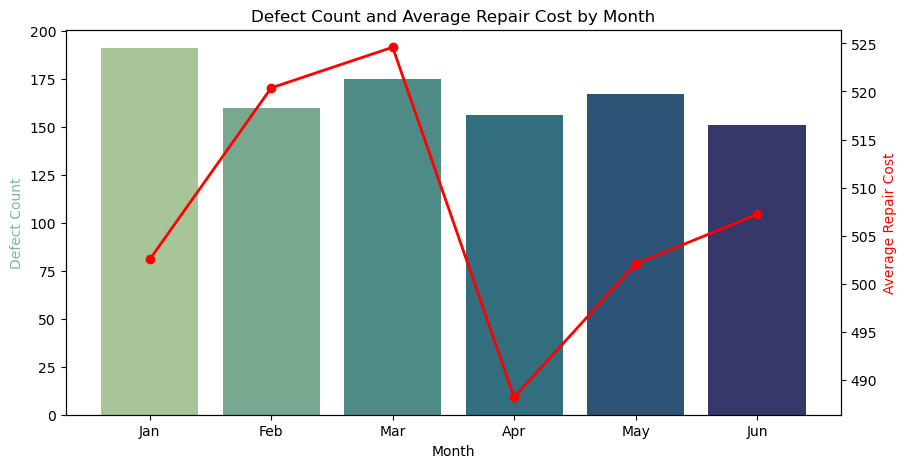

In [16]:
avg_cost_month = df.groupby("month")["repair_cost"].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10,5))

sns.countplot(x=df["month"], data=df, ax=ax1, palette="crest", hue=df["month"], legend=False)
ax1.set_ylabel("Defect Count", color=sns.color_palette("crest")[0])
ax1.set_xlabel("Month")
ax1.set_xticks(range(6))
ax1.set_xticklabels(month_labels)

ax2 = ax1.twinx()
ax2.plot(range(6), avg_cost_month["repair_cost"], color="red", marker="o", linewidth=2)
ax2.set_ylabel("Average Repair Cost", color="red")

plt.title("Defect Count and Average Repair Cost by Month")
plt.show()

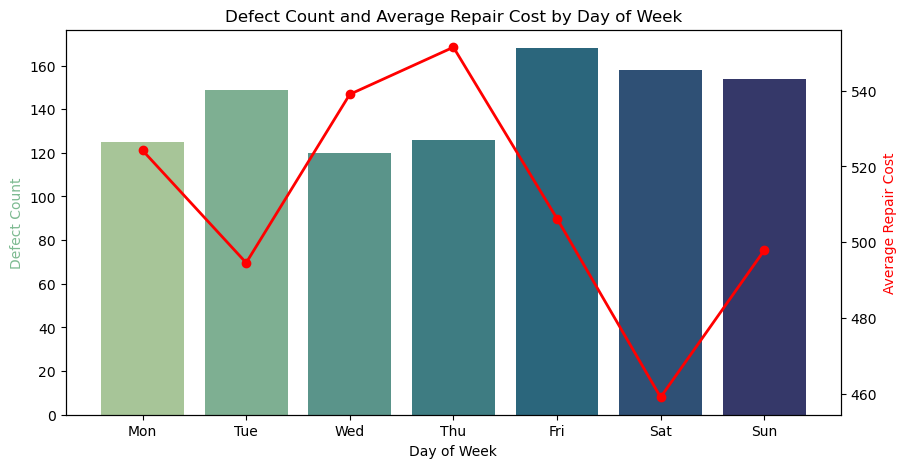

In [17]:
avg_dow = df.groupby("day_of_week")["repair_cost"].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10,5))

sns.countplot(x=df["day_of_week"], data=df, ax=ax1, palette="crest", hue=df["day_of_week"], legend=False)
ax1.set_ylabel("Defect Count", color=sns.color_palette("crest")[0])
ax1.set_xlabel("Day of Week")
ax1.set_xticks(range(7))
ax1.set_xticklabels(day_labels)

ax2 = ax1.twinx()
ax2.plot(range(7), avg_dow["repair_cost"], color="red", marker="o", linewidth=2)
ax2.set_ylabel("Average Repair Cost", color="red")

plt.title("Defect Count and Average Repair Cost by Day of Week")
plt.show()

In [18]:
df.columns

Index(['defect_id', 'product_id', 'defect_type', 'defect_date',
       'defect_location', 'severity', 'inspection_method', 'repair_cost',
       'date_converted', 'year', 'month', 'day_of_week'],
      dtype='object')

In [19]:
string_cols = ['product_id', 'defect_type','defect_location', 'severity', 'inspection_method']

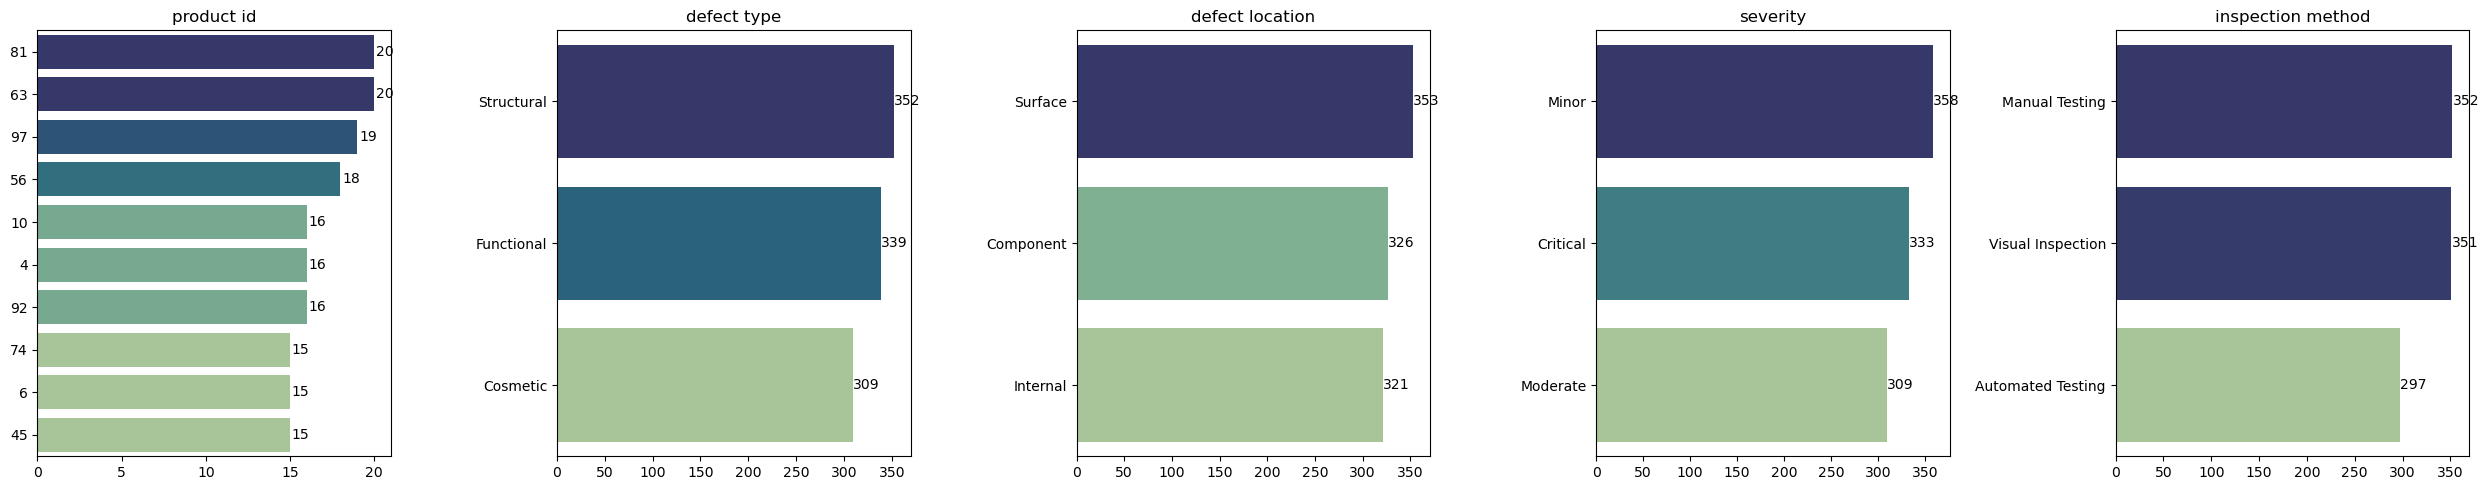

In [20]:
fig, axes = plt.subplots(ncols=len(string_cols), figsize=(5*len(string_cols),5))

for i, col in enumerate(string_cols):
    top_counts = df[col].value_counts().nlargest(10).reset_index()
    top_counts.columns = [col, "count"]
    
    sns.barplot(x="count", y=col, data=top_counts, ax=axes[i], palette="crest", hue="count", legend=False)
    
    # Add count labels on bars
    for p in axes[i].patches:
        axes[i].text(p.get_width() + 0.1, p.get_y() + p.get_height()/2, 
                     int(p.get_width()), va="center")
    
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(col.replace("_", " "))

plt.tight_layout()
plt.show()

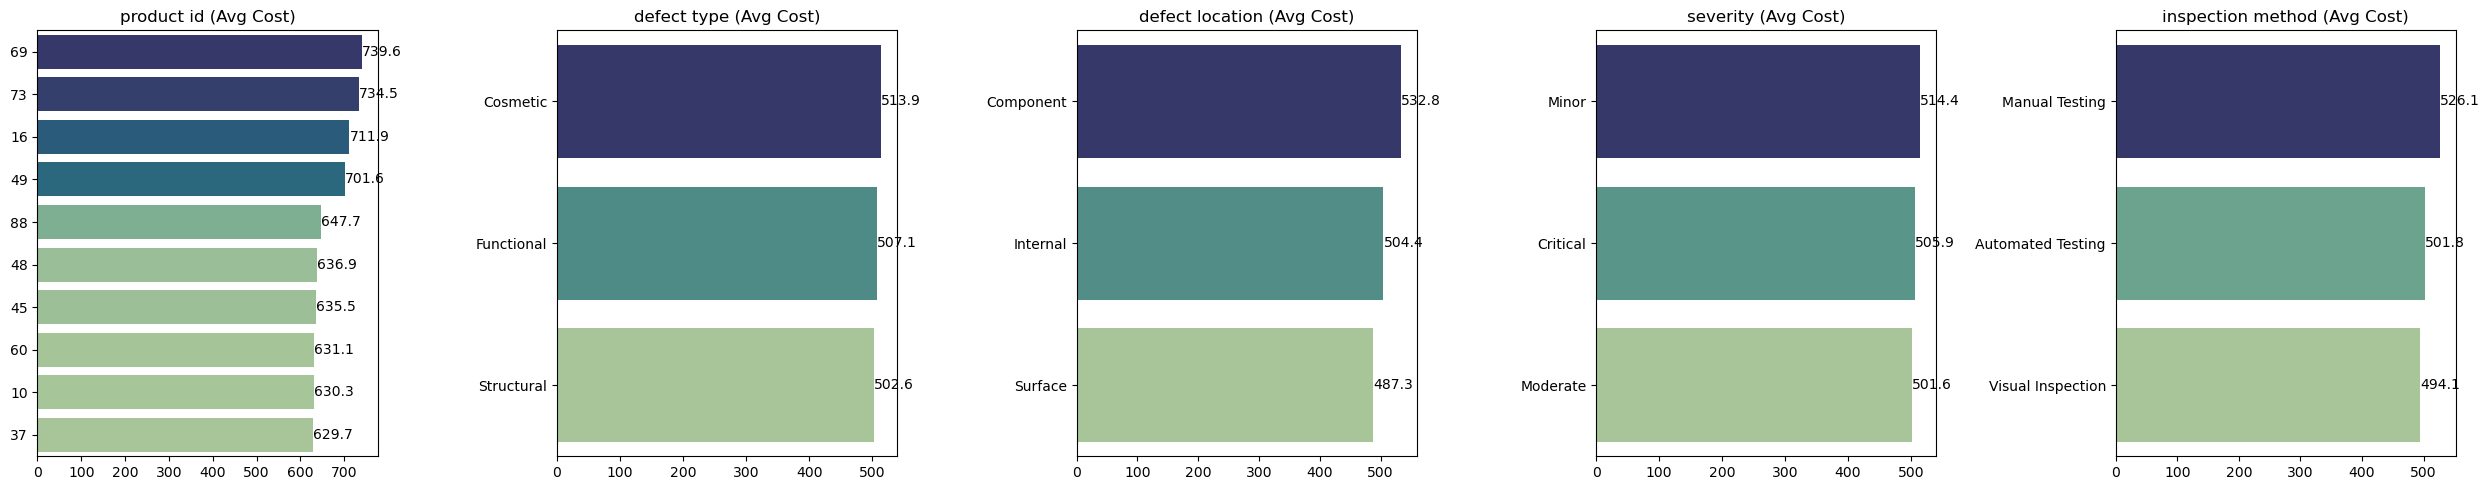

In [21]:
fig, axes = plt.subplots(ncols=len(string_cols), figsize=(5*len(string_cols), 5))

for i, col in enumerate(string_cols):
    avg_cost = (df.groupby(col)["repair_cost"].mean().nlargest(10).reset_index())
    avg_cost.columns = [col, "avg_repair_cost"]
    
    sns.barplot(x="avg_repair_cost", y=col,data=avg_cost,ax=axes[i],palette="crest",hue="avg_repair_cost",legend=False)
    
    for p in axes[i].patches:
        axes[i].text(p.get_width() + 0.1, p.get_y() + p.get_height()/2, f"{p.get_width():.1f}", va="center")
    
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(col.replace("_", " ") + " (Avg Cost)")

plt.tight_layout()
plt.show()

In [22]:
df.drop(["defect_id", "defect_date", "date_converted", "year"], axis=1, inplace = True)

## Train, Test, Split

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.repair_cost.values
y_val = df_val.repair_cost.values
y_test = df_test.repair_cost.values

del df_train["repair_cost"]
del df_val["repair_cost"]
del df_test["repair_cost"]

## Feature Columns

In [24]:
categorical = ['product_id', 'defect_type','defect_location', 'severity', 'inspection_method']
numerical = ['month', 'day_of_week']

## Dict Vectorizer

In [25]:
dv = DictVectorizer(sparse=False)

dict_train = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

dict_val = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(dict_val)

## Regression Error Metrics

In [26]:
def rmse(y_pred, y_val):
    return np.sqrt(np.mean((y_pred - y_val)**2))

def mae(y_pred, y_val):
    return np.mean((np.abs(y_pred - y_val)))

## Train Model

In [27]:
models = {
    "Linear Regression": LinearRegression(),

    "Decision Tree": DecisionTreeRegressor(
        max_depth=None,  
        min_samples_split=2,
        random_state=1
    ),

    "Random Forest": RandomForestRegressor(
        n_estimators=300,  
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        random_state=1
    ),

    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=1,
        n_jobs=-1
    ),
}

In [28]:
results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae_score = mae(y_pred, y_val)
    rmse_score = rmse(y_pred, y_val)
    results[name] = {"MAE": mae_score, "RMSE": rmse_score}
    
    print(f"MAE : {mae_score:.4f}")
    print(f"RMSE: {rmse_score:.4f}")


===== Linear Regression =====
MAE : 258.4736
RMSE: 313.2582

===== Decision Tree =====
MAE : 326.0741
RMSE: 409.2811

===== Random Forest =====
MAE : 253.6645
RMSE: 299.0509

===== XGBoost =====
MAE : 256.5157
RMSE: 307.9698


Since Random Forest Regressor has the lowest MAE and RMSE, this will be the base model used.

## Hyperparameter Tuning

In [29]:
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

best_mae = float("inf")
best_params = None
best_rmse = None


for n, d, s, l in itertools.product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
):

    model = RandomForestRegressor(
        n_estimators=n,
        max_depth=d,
        min_samples_split=s,
        min_samples_leaf=l,
        random_state=1,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    curr_mae = mae(y_pred, y_val)
    curr_rmse = rmse(y_pred, y_val)

    print(f"Params: n_estimators={n}, max_depth={d}, ")
    print(f"min_samples_split={s}, min_samples_leaf={l}")
    print(f"MAE : {curr_mae:.4f}")
    print(f"RMSE: {curr_rmse:.4f}\n")

    if curr_mae < best_mae:
        best_mae = curr_mae
        best_rmse = curr_rmse
        best_params = {
            "n_estimators": n,
            "max_depth": d,
            "min_samples_split": s,
            "min_samples_leaf": l
        }

print("===== BEST MODEL =====")
print(best_params)
print(f"Best MAE : {best_mae:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")


Params: n_estimators=100, max_depth=None, 
min_samples_split=2, min_samples_leaf=1
MAE : 254.6499
RMSE: 300.3166

Params: n_estimators=100, max_depth=None, 
min_samples_split=2, min_samples_leaf=2
MAE : 257.8052
RMSE: 301.2960

Params: n_estimators=100, max_depth=None, 
min_samples_split=2, min_samples_leaf=4
MAE : 254.5684
RMSE: 297.8085

Params: n_estimators=100, max_depth=None, 
min_samples_split=5, min_samples_leaf=1
MAE : 253.6782
RMSE: 298.9182

Params: n_estimators=100, max_depth=None, 
min_samples_split=5, min_samples_leaf=2
MAE : 257.0348
RMSE: 300.6930

Params: n_estimators=100, max_depth=None, 
min_samples_split=5, min_samples_leaf=4
MAE : 254.5684
RMSE: 297.8085

Params: n_estimators=100, max_depth=None, 
min_samples_split=10, min_samples_leaf=1
MAE : 254.6500
RMSE: 299.3731

Params: n_estimators=100, max_depth=None, 
min_samples_split=10, min_samples_leaf=2
MAE : 253.2954
RMSE: 297.3948

Params: n_estimators=100, max_depth=None, 
min_samples_split=10, min_samples_leaf=4
MA

## Evaluate Final Model on Test Set

In [30]:
y_full_train = df_full_train.repair_cost.values

del df_full_train["repair_cost"]

In [31]:
dict_full_train = df_full_train[categorical + numerical].to_dict(orient="records")
X_full_train = dv.fit_transform(dict_full_train)

In [32]:
dict_test = df_test[categorical + numerical].to_dict(orient="records")
X_test = dv.transform(dict_test)

In [33]:
final_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=1,
        n_jobs=-1
    )

final_model.fit(X_full_train, y_full_train)
y_pred = final_model.predict(X_test)
    
mae_score = mae(y_pred, y_test)
rmse_score = rmse(y_pred, y_test)
    
print(f"MAE : {mae_score:.4f}")
print(f"RMSE: {rmse_score:.4f}")

MAE : 255.7121
RMSE: 297.6687


## Feature Importance

In [34]:
importances = final_model.feature_importances_
features = list(dv.get_feature_names_out())

feature_imp_df = pd.DataFrame({"Feature": features, "Feature Importance": importances}).sort_values("Feature Importance", ascending=False) 
print(feature_imp_df)

           Feature  Feature Importance
0      day_of_week            0.062638
10           month            0.048834
29   product_id=25            0.045570
55   product_id=49            0.045251
39   product_id=34            0.037612
..             ...                 ...
13  product_id=100            0.000000
48   product_id=42            0.000000
22   product_id=19            0.000000
62   product_id=55            0.000000
87   product_id=78            0.000000

[114 rows x 2 columns]


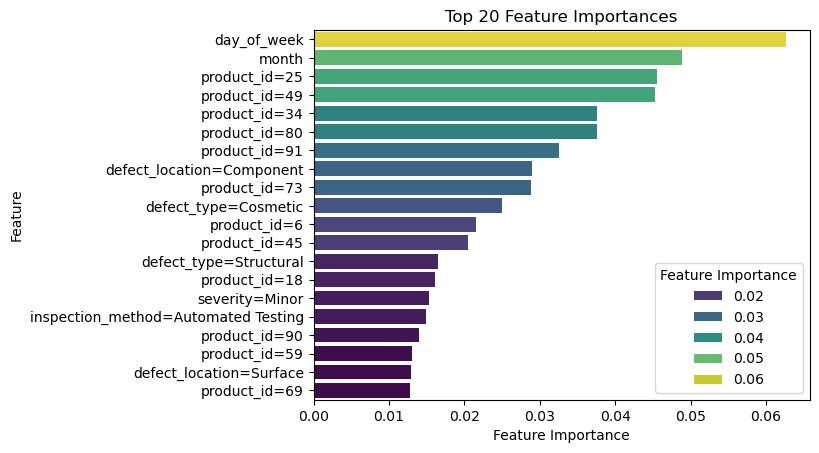

In [35]:
top_n = 20
sns.barplot(x="Feature Importance", y="Feature", data=feature_imp_df.head(top_n), palette="viridis", hue="Feature Importance")
plt.title("Top 20 Feature Importances")
plt.show()

## Save Model

In [36]:
with open("model.bin", "wb") as f_out:
    pickle.dump((dv, final_model), f_out)